# Task 1: Introduction

![Movies Collage](https://i.imgur.com/T7V0VZ6.png)

For this project we are going to create a recommendation engine for movies for users based on there past behaviour.

---

We will focus on the **collaborative filtering** approach, that is: 

The user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

---

Note: This notebook uses `python 3` and these packages: `pandas`, `numpy`, `matplotlib` and `scikit-surprise`

We can install them using:
```Shell
pip3 install pandas matplotlib numpy scikit-surprise
```

## 1.1: Installing Libraries

In [1]:
print('>> Installing Libraries')
!pip3 install pandas matplotlib numpy scikit-surprise



print('>> Libraries Installed')

>> Installing Libraries
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
>> Libraries Installed


## 1.2: Importing Libraries

First of all, we will need to import some libraries. This includes surprise which we will use to create the recommendation system.

In [2]:
print('>> Importing Libraries')

import pandas as pd

from surprise import Reader, Dataset, SVD

from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

print('>> Libraries imported.')

>> Importing Libraries
>> Libraries imported.


# Task 2: Importing Data

We will use open-source dataset from GroupLens Research ([movielens.org](http://movielens.org))

## 2.1: Importing the Data

The dataset is saved in a `ratings.csv` file. We will use pandas to take a look at some of the rows.

In [3]:
df=pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 2.2 Dropping timestamp

We won't be using the timestamp when user gave the particular rating. So we will drop that column.

In [4]:
df.drop('timestamp',axis=1,inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 2.3 Check for Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [5]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

# Task 3: EDA (Exploratory data analysis)

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics.

## 3.1 Number of movies/users

In [6]:
n_movies=df["movieId"].nunique()
n_users=df["userId"].nunique()
print(f'Number of unique movies:{n_movies}')
print(f'Number of unique users:{n_users}')


Number of unique movies:9724
Number of unique users:610


## 3.2 Sparsity of our data

Sparsity (%) = `(No of missing values/ (Total Values))X100`

In [7]:
available_ratings=df['rating'].count()
total_ratings=n_movies*n_users
missing_ratings=total_ratings-available_ratings
sparsity=(missing_ratings/total_ratings)*100
print(f'Sparsity:{sparsity}')


Sparsity:98.30003169443864


## 3.3 Ratings Distribution

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

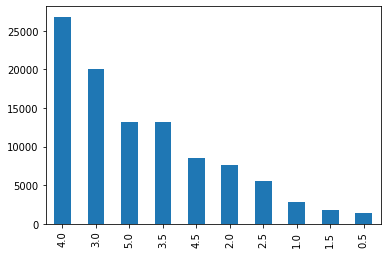

In [8]:
df['rating'].value_counts().plot(kind='bar')

# Task 4: Dimensionality Reduction

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

## 4.1 Filter movies with less than 3 ratings

In [9]:
filter_movies=df['movieId'].value_counts()>3
filter_movies= filter_movies[filter_movies].index.tolist()

## 4.2 Filter users with less than 3 movies rated

In [11]:
filter_users=df['userId'].value_counts()>3
filter_users=filter_users[filter_users].index.tolist()

## 4.3 Remove rarely rated movies and rarely rating users

In [15]:

df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
print(f'New shape:{df.shape}')


New shape:(92394, 3)


# Task 5: Create Training and Test Sets

## 5.1 Columns used for training

In [16]:
cols=['userId','movieId','rating']

## 5.2 Create surprise dataset

In [17]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(df[cols],reader)

## 5.3 Create Train-set and Prediction-set

In [18]:
trainset = data.build_full_trainset()
antiset = trainset.build_anti_testset()

# Task 6: Creating and training the model

## 6.1 Creating the model

**SVD (Singular Value Decomposition)**

Interaction Matrix = A X B X C

In [19]:
algo=SVD(n_epochs=25 , verbose=True)

## 6.2 Training the model

**Mean Absolute Error (MAE)**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 

**Root mean squared error (RMSE)**:  RMSE is the square root of the average of squared differences between prediction and actual observation.

In [20]:
cross_validate(algo,data,measures=['RMSE','MAE'],cv=5,verbose=True)
print('Training done')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

# Task 7: Predictions

## 7.1 Predict ratings for all pairs (user, items) that are NOT in the training set.

In [21]:
predictions = algo.test(antiset)

In [22]:
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

## 7.2 Recommending top 3 movies movies based on predictions

In [23]:
from collections import defaultdict
def get_top_n(predictions,n):
    top_n = defaultdict(list)
    for uid,iid,_,est,_ in predictions:
        top_n[uid].append((iid,est))
        
    for uid,user_ratings in top_n.items():
        user_ratings.sort(key=lambda x:x[1],reverse=True)
        top_n[uid]=user_ratings[:n]
    return top_n
    pass
top_n = get_top_n(predictions,n=3)
for uid,user_ratings in top_n.items():
    print(uid,[iid for (iid,rating)in user_ratings])

1 [318, 48516, 58559]
2 [1276, 1217, 1204]
3 [56782, 3275, 4034]
4 [5952, 3147, 177593]
5 [898, 904, 1233]
6 [1203, 44195, 177593]
7 [898, 838, 541]
8 [2959, 858, 904]
9 [1204, 1258, 3147]
10 [2398, 5060, 1225]
11 [1221, 177593, 58559]
12 [356, 527, 1089]
13 [750, 2959, 7153]
14 [1204, 1208, 541]
15 [1242, 608, 1197]
16 [898, 910, 44195]
17 [1204, 1199, 246]
18 [750, 2858, 898]
19 [4973, 858, 1221]
20 [1080, 2716, 1207]
21 [5690, 1204, 2791]
22 [2019, 57669, 71899]
23 [1204, 1261, 3972]
24 [750, 904, 912]
25 [1197, 2959, 318]
26 [1204, 527, 1258]
27 [1204, 858, 1080]
28 [1261, 3703, 1203]
29 [1237, 177593, 3275]
30 [50, 1206, 68157]
31 [318, 778, 1225]
32 [904, 858, 356]
33 [4226, 6807, 898]
34 [2398, 1148, 1261]
35 [858, 1148, 1221]
36 [750, 858, 2959]
37 [750, 1204, 1198]
38 [1204, 1041, 7361]
39 [1237, 3949, 1201]
40 [858, 1276, 36]
41 [1204, 4995, 3468]
42 [1252, 2324, 2160]
43 [6, 50, 593]
44 [1204, 1283, 27773]
45 [2160, 1204, 1251]
46 [2959, 3703, 1204]
47 [1204, 866, 1250]
48 [